# Python Package Installation

In [ ]:
!pip install openai
!pip install openai-cli
!pip install transformers
!pip install pyarrow
!pip install pinecone-client
!pip install tqdm

# Import the Python Libraries

In [16]:
import openai
from openai.embeddings_utils import get_embedding

import pandas as pd
import numpy as np
import pyarrow
import pinecone

from transformers import GPT2TokenizerFast

from sys import getsizeof
from tqdm.auto import tqdm
import json
import time



# Dataset Preparation

* Dataset is taken from Kaggle https://www.kaggle.com/datasets/jithinanievarghese/drugs-side-effects-and-medical-condition?resource=download
* Took only 3 columns out of this dataset (drug_name, medical_condition and side_effects)
* Renamed the side_effects column as the context column
* Added the question column based on drug_name and medical_condition
* Combined all the text data into text column with keys topic, question and answer
* Used the transformer pre-trained gp2 tokenizer to get the number of tokens (feature vectors) for the given text in the text column

In [66]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
df = pd.read_csv('./drug-side-effects.csv')
df = df[["drug_name","medical_condition", "side_effects"]]
df = df.dropna()
df = df.assign(questions=lambda x: "what is the side effect of taking drug " + x.drug_name + "for the " + x.medical_condition + " medical condition.")
questions = df.pop('questions')
df.insert(2, 'questions', questions)
df.rename(columns = {'side_effects':'context'}, inplace = True)
df['text'] = "Topic: " + df.drug_name + " - " + df.medical_condition + "; Question: " + df.medical_condition + " - " + df.questions + "; Answer: " + df.context
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (1104 > 1024). Running this sequence through the model will result in indexing errors


,drug_name,medical_condition,questions,context,text,n_tokens
0,doxycycline,Acne,what is the side effect of taking drug doxycyc...,"(hives, difficult breathing, swelling in your ...",Topic: doxycycline - Acne; Question: Acne - wh...,339
1,spironolactone,Acne,what is the side effect of taking drug spirono...,hives ; difficulty breathing; swelling of your...,Topic: spironolactone - Acne; Question: Acne -...,166
2,minocycline,Acne,what is the side effect of taking drug minocyc...,"skin rash, fever, swollen glands, flu-like sym...",Topic: minocycline - Acne; Question: Acne - wh...,333
3,Accutane,Acne,what is the side effect of taking drug Accutan...,problems with your vision or hearing; muscle o...,Topic: Accutane - Acne; Question: Acne - what ...,274
4,clindamycin,Acne,what is the side effect of taking drug clindam...,hives ; difficult breathing; swelling of your ...,Topic: clindamycin - Acne; Question: Acne - wh...,151


* Checking the histogram for the distribution of tokens in the dataset

<AxesSubplot:>

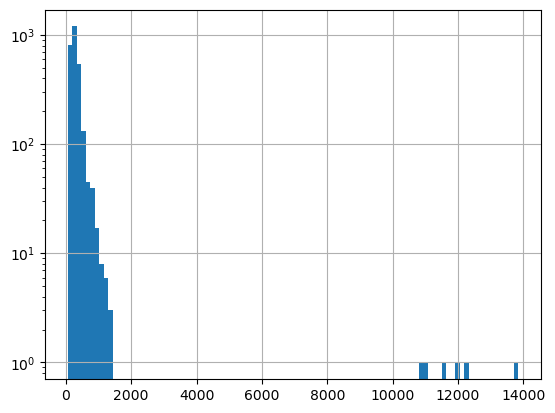

In [67]:
df.n_tokens.hist(bins=100, log=True)

* Trim the dataset , remove data above 2000 tokens

In [68]:
df = df[df.n_tokens < 2000]

# Get embedding vector list from OpenAI Embedding Model
* Model selected is "text-search-curie-doc-001"
* Free tier API rate limit is 60 per minute, so for every 50 rows in the dataframe give a sleep interval of 1 minute.
* It took 3 hrs and $14 in free tier expense to get the vector list for each row.
* Finally stored the vector list in Parquet format. 

In [ ]:
openai.api_key = '<>'
model = 'curie'
count = 0
embed_array = []
for index, row in df.iterrows():
    count += 1
    embed_array.append(get_embedding(row['text'], engine=f'text-search-{model}-doc-001'))
    if count == 50:
        time.sleep(62)
        count = 0 
    
df.insert(6, "embeddings", embed_array, True)       
df.to_parquet('/Users/rajthith/openai/curie_embeddings.parquet')
df.head()

In [77]:
df1 = pd.read_parquet('./curie_embeddings.parquet')
df1.head()

,drug_name,medical_condition,questions,context,text,n_tokens,embeddings
0,doxycycline,Acne,what is the side effect of taking drug doxycyc...,"(hives, difficult breathing, swelling in your ...",Topic: doxycycline - Acne; Question: Acne - wh...,339,"[-0.01912190206348896, 0.009189479984343052, 0..."
1,spironolactone,Acne,what is the side effect of taking drug spirono...,hives ; difficulty breathing; swelling of your...,Topic: spironolactone - Acne; Question: Acne -...,166,"[-0.007099879439920187, 0.008844921365380287, ..."
2,minocycline,Acne,what is the side effect of taking drug minocyc...,"skin rash, fever, swollen glands, flu-like sym...",Topic: minocycline - Acne; Question: Acne - wh...,333,"[-0.01001330092549324, -0.013359921053051949, ..."
3,Accutane,Acne,what is the side effect of taking drug Accutan...,problems with your vision or hearing; muscle o...,Topic: Accutane - Acne; Question: Acne - what ...,274,"[-0.01733020693063736, -0.01158748846501112, 0..."
4,clindamycin,Acne,what is the side effect of taking drug clindam...,hives ; difficult breathing; swelling of your ...,Topic: clindamycin - Acne; Question: Acne - wh...,151,"[-0.008103083819150925, 0.0049868617206811905,..."


# Creation of Pinecone Index for embedding Vectors list
* Pincode DB cannot have metadata size greater than 5 KB, so we will assign a unique id for each row and use that mapping for our text data
* Create Pinecode Index after initializing the pinecone client with API key and environment, we will use cosine similarity metric for our vector embeddings.
* Update the Index with the vectors list.
* Create a metadata mapping with id and text columns to see if we are able to retrieve the context from the pinecone vector DB

In [78]:
too_big = []

for text in df['text'].tolist():
    if getsizeof(text) > 5000:
        too_big.append((text, getsizeof(text)))

print(f"{len(too_big)} / {len(df)} records are too big")

48 / 2801 records are too big


In [79]:
df['id'] = [str(i) for i in range(len(df))]
df.head()

,drug_name,medical_condition,questions,context,text,n_tokens,embeddings,id
0,doxycycline,Acne,what is the side effect of taking drug doxycyc...,"(hives, difficult breathing, swelling in your ...",Topic: doxycycline - Acne; Question: Acne - wh...,339,"[-0.01912190206348896, 0.009189479984343052, 0...",0
1,spironolactone,Acne,what is the side effect of taking drug spirono...,hives ; difficulty breathing; swelling of your...,Topic: spironolactone - Acne; Question: Acne -...,166,"[-0.007099879439920187, 0.008844921365380287, ...",1
2,minocycline,Acne,what is the side effect of taking drug minocyc...,"skin rash, fever, swollen glands, flu-like sym...",Topic: minocycline - Acne; Question: Acne - wh...,333,"[-0.01001330092549324, -0.013359921053051949, ...",2
3,Accutane,Acne,what is the side effect of taking drug Accutan...,problems with your vision or hearing; muscle o...,Topic: Accutane - Acne; Question: Acne - what ...,274,"[-0.01733020693063736, -0.01158748846501112, 0...",3
4,clindamycin,Acne,what is the side effect of taking drug clindam...,hives ; difficult breathing; swelling of your ...,Topic: clindamycin - Acne; Question: Acne - wh...,151,"[-0.008103083819150925, 0.0049868617206811905,...",4


In [81]:
pinecone.init(
    api_key='<>', 
    environment='us-west1-gcp'
)

index_name = 'chatgpt-demo'

if not index_name in pinecone.list_indexes():
    pinecone.create_index(
        index_name, dimension=len(df['embeddings'].tolist()[0]),
        metric='cosine'
    )

index = pinecone.Index(index_name)

In [83]:
batch_size = 32

for i in tqdm(range(0, len(df), batch_size)):
    i_end = min(i+batch_size, len(df))
    df_slice = df.iloc[i:i_end]
    to_upsert = [
        (
            row['id'],
            row['embeddings'],
            {
                'drug_name': row['drug_name'],
                'medical_condition': row['medical_condition'],
                'n_tokens': row['n_tokens']
            }
        ) for _, row in df_slice.iterrows()
    ]
    index.upsert(vectors=to_upsert)

  0%|          | 0/88 [00:00<?, ?it/s]

In [84]:
mappings = {row['id']: row['text'] for _, row in df[['id', 'text']].iterrows()}

In [85]:
with open('./mapping.json', 'w') as fp:
    json.dump(mappings, fp)

# Test the Question & Answer system
* Load the Pinecode Index
* Test the context retrieval from the context embeddings in Pinecone
* Build the query, encode it, retrieve the context after passing on to the OpenAI generative model "text-davinci-002"
* Add the required instructions, so the model generates the output based on give instructions. 

In [86]:
def load_index():
    pinecone.init(
        api_key='<>',  # app.pinecone.io
        environment='us-west1-gcp'
    )

    index_name = 'chatgpt-demo'

    if not index_name in pinecone.list_indexes():
        raise KeyError(f"Index '{index_name}' does not exist.")

    return pinecone.Index(index_name)

In [87]:
index = load_index()

In [88]:
def create_context(question, index, max_len=3750, size="curie"):
    """
    Find most relevant context for a question via Pinecone search
    """
    q_embed = get_embedding(question, engine=f'text-search-{size}-query-001')
    res = index.query(q_embed, top_k=5, include_metadata=True)
    

    cur_len = 0
    contexts = []

    for row in res['matches']:
        text = mappings[row['id']]
        cur_len += row['metadata']['n_tokens'] + 4
        if cur_len < max_len:
            contexts.append(text)
        else:
            cur_len -= row['metadata']['n_tokens'] + 4
            if max_len - cur_len < 200:
                break
    return "\n\n###\n\n".join(contexts)

In [89]:
create_context("what is the side effect of taking drug doxycycline for Acne medical condition", index)

'Topic: doxycycline - Acne; Question: Acne - what is the side effect of taking drug doxycyclinefor the Acne medical condition.; Answer: (hives, difficult breathing, swelling in your face or throat) or a severe skin reaction (fever, sore throat, burning in your eyes, skin pain, red or purple skin rash that spreads and causes blistering and peeling). Seek medical treatment if you have a serious drug reaction that can affect many parts of your body. Symptoms may include: skin rash, fever, swollen glands, flu-like symptoms, muscle aches, severe weakness, unusual bruising, or yellowing of your skin or eyes. This reaction may occur several weeks after you began using doxycycline. Doxycycline may cause serious side effects. Call your doctor at once if you have: severe stomach pain, diarrhea that is watery or bloody; throat irritation, trouble swallowing; chest pain, irregular heart rhythm, feeling short of breath; little or no urination; low white blood cell counts - fever, chills, swollen gl

In [98]:
def answer_question(
    index=index,
    fine_tuned_qa_model="text-davinci-002",
    question="Do i get any side effect if I take ibuprofen?",
    instruction="Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext:\n{0}\n\n---\n\nQuestion: {1}\nAnswer:",
    max_len=3550,
    size="curie",
    debug=False,
    max_tokens=400,
    stop_sequence=None,
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        index,
        max_len=max_len,
        size=size,
    )
    if debug:
        print("Context:\n" + context)
        print("\n\n")
    try:
        # fine-tuned models requires model parameter, whereas other models require engine parameter
        model_param = (
            {"model": fine_tuned_qa_model}
            if ":" in fine_tuned_qa_model
            and fine_tuned_qa_model.split(":")[1].startswith("ft")
            else {"engine": fine_tuned_qa_model}
        )
        #print(instruction.format(context, question))
        response = openai.Completion.create(
            prompt=instruction.format(context, question),
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            **model_param,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [92]:
instructions = {
    "conservative Q&A": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext:\n{0}\n\n---\n\nQuestion: {1}\nAnswer:",
    "paragraph about a question":"Write a paragraph, addressing the question, and use the text below to obtain relevant information\"\n\nContext:\n{0}\n\n---\n\nQuestion: {1}\nParagraph long Answer:",
    "bullet point": "Write a bullet point list of possible answers, addressing the question, and use the text below to obtain relevant information\"\n\nContext:\n{0}\n\n---\n\nQuestion: {1}\nBullet point Answer:",
    "summarize problems given a topic": "Write a summary of the problems addressed by the questions below\"\n\n{0}\n\n---\n\n",
    "just instruction": "{1} given the common questions and answers below \n\n{0}\n\n---\n\n",
    "summarize": "Write an elaborate, paragraph long summary about \"{1}\" given the questions and answers from a public forum on this topic\n\n{0}\n\n---\n\nSummary:",
}

In [93]:
print(answer_question(index, question="are there side effects for paracetamol drug", 
                            instruction = instructions["summarize problems given a topic"], debug=False))

The questions above address the potential side effects of taking the drug Paracetamol for pain relief. Paracetamol is a common pain reliever, but it can have serious side effects, including liver damage, kidney damage, and gastrointestinal bleeding. If you experience any of the rare side effects listed above, you should stop taking the drug and seek medical help immediately.


In [95]:
print(answer_question(index, question="are there side effects for paracetamol drug", 
                            instruction = instructions["conservative Q&A"], debug=False))

Serious side effects of paracetamol include: Allergic reactions, which may be severe and include: Skin rashes, itching or hives Swelling of the throat, tongue or face Shortness of breath or wheezing Skin rash or peeling, or mouth ulcers Breathing problems. This is more likely if you have experienced them before when taking other painkillers such as ibuprofen and aspirin Unexplained bruising or bleeding or becoming unusually tired. Getting more infections than usual. Liver problems. Nausea, sudden weight loss, loss of appetite and yellowing of the eyes and skin can occur If you get any of the rare side effects listed above, stop taking the medicine and contact your doctor immediately. Common side effect of paracetamol suppositories include: Redness or soreness in or around the rectum Everyday, long-term use (several months or more) of paracetamol can cause liver or kidney damage. People taking this medication in the usual way for shorter periods of time have not had these problems. Thes

In [99]:
print(answer_question())

Ibuprofen may cause serious side effects. Stop using ibuprofen and call your doctor at once if you have: changes in your vision; shortness of breath (even with mild exertion); swelling or rapid weight gain; a skin rash, no matter how mild; signs of stomach bleeding - bloody or tarry stools, coughing up blood or vomit that looks like coffee grounds; liver problems - nausea, upper stomach pain, itching, tired feeling, flu-like symptoms, loss of appetite, dark urine, clay-colored stools, jaundice (yellowing of the skin or eyes); low red blood cells (anemia) - pale skin, feeling light-headed or short of breath, rapid heart rate, trouble concentrating; or kidney problems - little or no urinating, painful or difficult urination, swelling in your feet or ankles, feeling tired or short of breath. Common ibuprofen side effects may include: nausea, vomiting, gas; bleeding; or dizziness, headache.


In [100]:
print(answer_question(index, question="I am planning to take cefixime drug, do i get any side effect", 
                            instruction = instructions["summarize"], debug=False))

Cefixime is a drug used to treat pneumonia, and its side effects can include severe stomach pain, diarrhea, and seizures. Cefadroxil is a drug used to treat UTIs, and its side effects can include hives, difficulty breathing, and swelling of the face, lips, or tongue. Cefiderocol is a drug used to treat UTIs, and its side effects can include severe stomach pain, diarrhea, and low potassium levels.


In [102]:
print(answer_question(index, question="I am taking metoclopramide drug, what are the side effects", 
                            instruction = instructions["bullet point"], debug=False))

-Hives
-Difficult breathing 
-Swelling of face, lips, tongue, or throat 
-Tremors or shaking in arms or legs 
-Uncontrolled muscle movements in face 
-Confusion 
-Depression 
-Thoughts of suicide or hurting oneself 
-Slow or jerky muscle movements 
-Problems with balance or walking 
-Mask-like appearance in face 
-Seizure 
-Anxiety
-Agitation 
-Jittery feeling 
-Trouble staying still 
-Trouble sleeping 
-Swelling 
-Feeling short of breath 
-Rapid weight gain 
-Severe nervous system reaction 
-Very stiff (rigid) muscles 
-High fever 
-Sweating 
-Fast or uneven heartbeats 
-Nausea 
-Vomiting 
-Headache 
-Lack of energy 
-Sleep problems (insomnia)
